<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task2_Data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 任务完成
+ 基础的数据扩增方法学习
+ 使用OpenCV和albumentations完成数据扩增
+ Pytorch 完成赛题读取
+ baseline 数据增强的优化

## 常见数据增强的方法

数据扩增是一种有效的正则化方法，可以防止模型过拟合，在深度学习模型的训练过程中应用广泛。数据扩增的目的是增加数据集中样本的数据量，同时也可以有效增加样本的语义空间。
需注意：
+ 不同的数据，拥有不同的数据扩增方法；
+ 数据扩增方法需要考虑合理性，不要随意使用；
+ 数据扩增方法需要与具体任何相结合，同时要考虑到标签的变化；
对于图像分类，数据扩增方法可以分为两类：
+ 标签不变的数据扩增方法：数据变换之后图像类别不变；
+ 标签变化的数据扩增方法：数据变换之后图像类别变化；
而对于语义分割而言，常规的数据扩增方法都会改变图像的标签。如水平翻转、垂直翻转、旋转90%、旋转和随机裁剪，这些常见的数据扩增方法都会改变图像的标签，即会导致地标建筑物的像素发生改变。


### OpenCV数据扩增
OpenCV是计算机视觉必备的库，可以很方便的完成数据读取、图像变化、边缘检测和模式识别等任务。

In [4]:
!cp /content/drive/MyDrive/dataset/train.zip /content/

In [5]:
!cp /content/drive/MyDrive/dataset/test_a.zip /content/

In [6]:
!cp /content/drive/MyDrive/dataset/test_a_samplesubmit.csv  /content/

In [7]:
!cp /content/drive/MyDrive/dataset/train_mask.csv  /content/

In [ ]:
!unzip /content/test_a.zip

In [ ]:
!unzip /content/train.zip

RLE与图片之间的转换

In [1]:
import numpy as np
import pandas as pd
import cv2

# 将图片编码为rle格式
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 将rle格式进行解码为图片
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [2]:
train_mask = pd.read_csv('train_mask.csv', sep='\t', names=['name', 'mask']) #读取mask

(-0.5, 511.5, 511.5, -0.5)

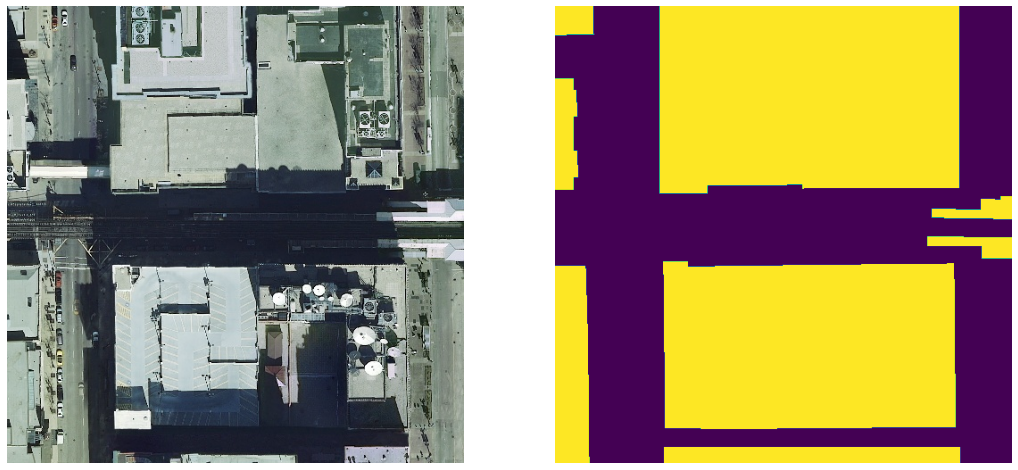

In [3]:
import matplotlib.pyplot as plt
# 首先读取原始图片
img = cv2.imread('train/' + train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])
plt.figure(figsize=(18,12))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis("off")

### cv2 垂直翻转

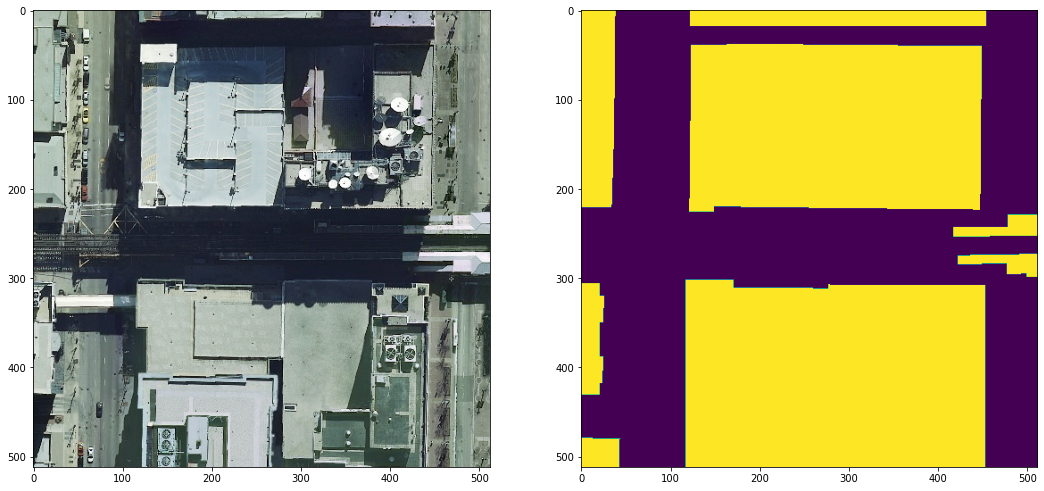

In [4]:
plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.imshow(cv2.flip(img, 0))

plt.subplot(1, 2, 2)
plt.imshow(cv2.flip(mask, 0))

### cv2 水平翻转

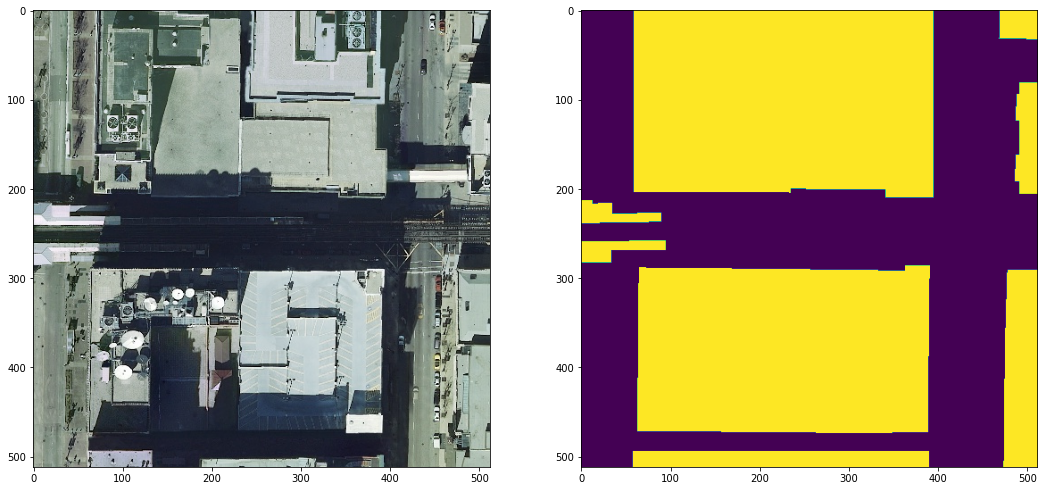

In [5]:
plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.imshow(cv2.flip(img, 90))

plt.subplot(1, 2, 2)
plt.imshow(cv2.flip(mask, 90))

### cv2 随机剪裁


In [6]:
img.shape

(512, 512, 3)

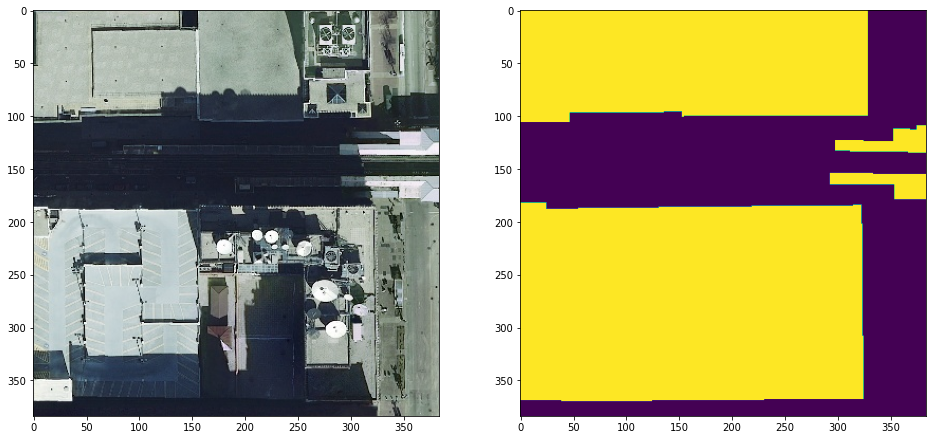

In [7]:
x, y = np.random.randint(0, 128), np.random.randint(0, 128)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img[x:x+384, y:y+384])

plt.subplot(1, 2, 2)
plt.imshow(mask[x:x+384, y:y+384])

### OpenCV完成图像加噪数据扩增

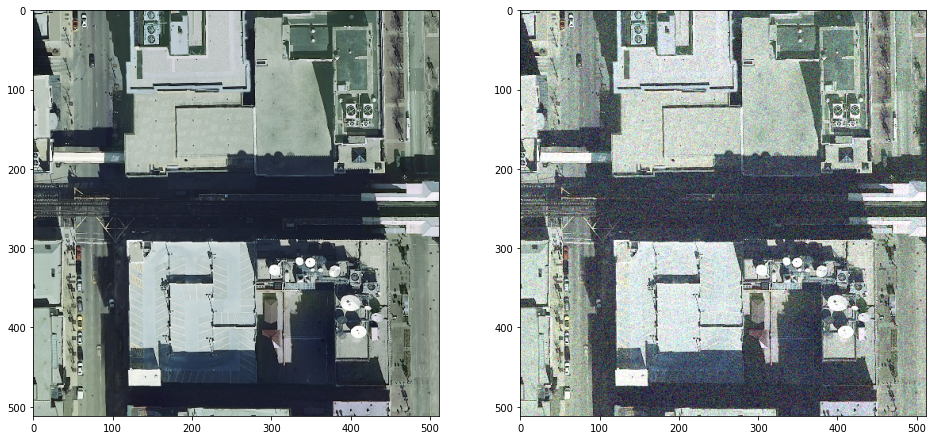

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
 
def mat2gray(img):
    A = np.double(img)
    out = np.zeros(A.shape, np.double)
    normalized = cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX)
    return out
 
#添加噪声到图像
def random_noise(image, mode='gaussian', seed=None, clip=True, **kwargs):
    image = mat2gray(image)
    
    mode = mode.lower()
    if image.min() < 0:
        low_clip = -1
    else:
        low_clip = 0
    if seed is not None:
        np.random.seed(seed=seed)
        
    if mode == 'gaussian':
        noise = np.random.normal(kwargs['mean'], kwargs['var'] ** 0.5,
                                 image.shape)        
        out = image  + noise
    if clip:        
        out = np.clip(out, low_clip, 1.0)
        
    return out

#添加高斯噪声
img1 = random_noise(img,'gaussian', mean=0.1,var=0.01)
img1 = np.uint8(img1*255)
 
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img1)


用OpenCV完成图像旋转数据扩增；

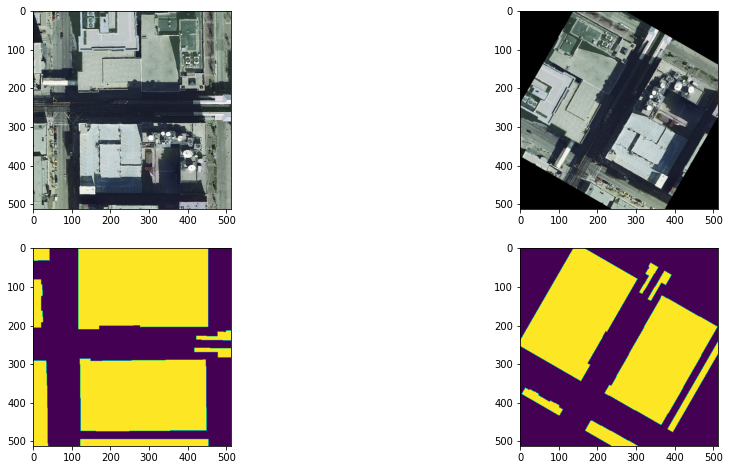

In [9]:
#旋转
def rotate(image, angle=15, scale=0.9):
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv2.warpAffine(image,M,(w,h))
    return image
img2 = rotate(img,60)
mask2 = rotate(mask,60)
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.imshow(img2)
plt.subplot(2, 2, 3)
plt.imshow(mask)
plt.subplot(2, 2, 4)
plt.imshow(mask2)

### albumentations数据扩增
albumentations是基于OpenCV的快速训练数据增强库，拥有非常简单且强大的可以用于多种任务（分割、检测）的接口，易于定制且添加其他框架非常方便。albumentations也是计算机视觉数据竞赛中最常用的库。

与OpenCV相比albumentations具有以下优点：

+ albumentations支持的操作更多，使用更加方便；
+ albumentations可以与深度学习框架（Keras或Pytorch）配合使用；
+ albumentations支持各种任务（图像分流）的数据扩增操作

albumentations它可以对数据集进行逐像素的转换，如模糊、下采样、高斯造点、高斯模糊、动态模糊、RGB转换、随机雾化等；也可以进行空间转换（同时也会对目标进行转换），如裁剪、翻转、随机裁剪等。

In [10]:
import albumentations as A
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

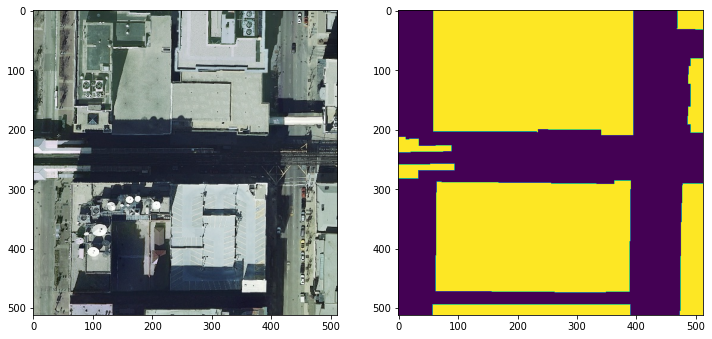

In [11]:
# 水平翻转
augments = A.HorizontalFlip(p=1)(image=img, mask=mask)
img_aug, mask_aug = augments['image'], augments['mask']

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_aug)
plt.subplot(1, 2, 2)
plt.imshow(mask_aug)


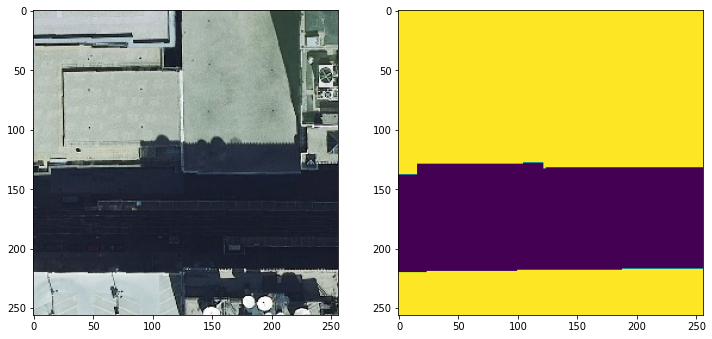

In [12]:
# 随机裁剪
augments = A.RandomCrop(p=1, height=256, width=256)(image=img, mask=mask)
img_aug, mask_aug = augments['image'], augments['mask']
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_aug)
plt.subplot(1, 2, 2)
plt.imshow(mask_aug)


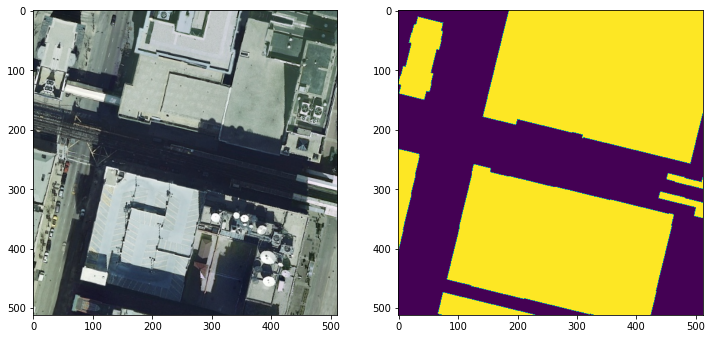

In [13]:
# 旋转
augments = A.ShiftScaleRotate(p=1)(image=img, mask=mask)
img_aug, mask_aug = augments['image'], augments['mask']
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_aug)
plt.subplot(1, 2, 2)
plt.imshow(mask_aug)

albumentations还可以组合多个数据扩增操作得到更加复杂的数据扩增操作：

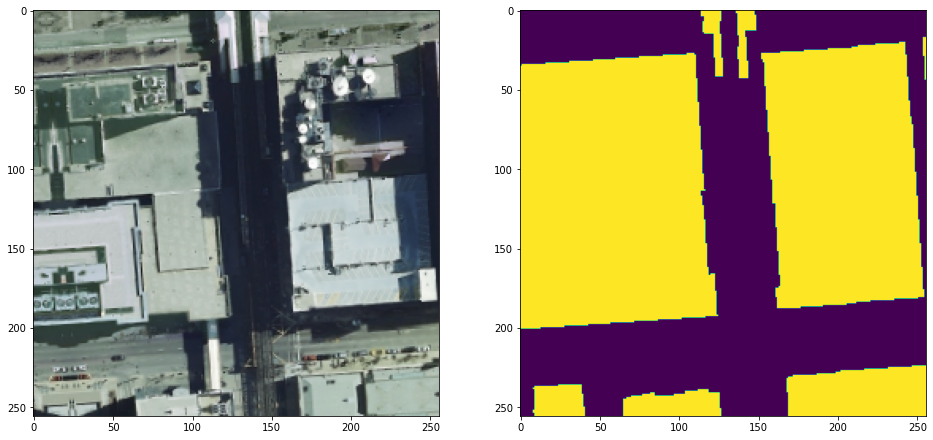

In [14]:
trfm = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.ShiftScaleRotate(p=0.5)
])

augments = trfm(image=img, mask=mask)
img_aug, mask_aug = augments['image'], augments['mask']
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_aug)

plt.subplot(1, 2, 2)
plt.imshow(mask_aug)

### Pytorch数据读取
使用Pytorch读取赛题数据。在Pytorch中数据是通过Dataset进行封装，并通过DataLoder进行并行读取。所以我们只需要重载一下数据读取的逻辑就可以完成数据的读取。

+ Dataset：数据集，对数据进行读取并进行数据扩增；
+ DataLoder：数据读取器，对Dataset进行封装并进行批量读取；
+ 定义Dataset：

In [15]:
import torch.utils.data as D
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.len = len(paths)

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        mask = rle_decode(self.rles[index])
        augments = self.transform(image=img, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
   
    def __len__(self):
        return self.len

实例化Dataset：

In [ ]:
IMAGE_SIZE = 256
trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.ShiftScaleRotate(p=0.5)

])

dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm
)

实例化DataLoder，批大小为10：

In [ ]:
loader = D.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0)

### baseline 优化数据增强

In [ ]:
!pip install rasterio

In [1]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

import rasterio
from rasterio.windows import Window

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

In [3]:

EPOCHES = 10
BATCH_SIZE = 32
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.ShiftScaleRotate(p=0.5)
])

In [4]:

class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len    

In [5]:
train_mask = pd.read_csv('/content/train_mask.csv', sep='\t', names=['name', 'mask'])


In [6]:
train_mask['name'] = train_mask['name'].apply(lambda x: '/content/train/' + x)

In [7]:
train_mask.shape

(30000, 2)

In [8]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

In [9]:
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 5 == 0:
        valid_idx.append(i)
    else:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [10]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    
#     pth = torch.load("../input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth")
#     for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
#         del pth[key]
    
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [11]:
model = get_model()
model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

In [ ]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 10
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), '/content/drive/MyDrive/dataset/result/model_best.pth')

In [13]:

trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

subm = []

model.load_state_dict(torch.load("/content/drive/MyDrive/dataset/result/model_best.pth"))
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [14]:
test_mask = pd.read_csv('/content/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: '/content/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

In [15]:
subm = pd.DataFrame(subm)
subm.to_csv('/content/result.csv', index=None, header=None, sep='\t')